Imports and load data

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
import shap



file_path = './data/synthetic_data_lung_cancer.csv'
df = pd.read_csv(file_path)

Feature engeneering

In [41]:
# Scale the 'TIME' column
scaler = MinMaxScaler()
df[['TIME']] = scaler.fit_transform(df[['TIME']])
# Feature engineering: Create features based on unique interventions
df_features = pd.pivot_table(df, index='SUBJECT_ID', columns='DEFINITION_ID', values='TIME', aggfunc='count', fill_value=0)
# Create the target column for 1-year mortality (assuming 'death' is the label for mortality)
df['TARGET'] = 0  # Initialize as 0
df.loc[df['DEFINITION_ID'] == 'death', 'TARGET'] = 1  # Set to 1 for mortality events
# Aggregate the target variable to match the number of unique subjects
df_target = df.groupby('SUBJECT_ID')['TARGET'].max()
X = df_features.values  # Features as a NumPy array
y = df_target.values # Target as a NumPy array


Data cleaning

In [42]:
# Handle Missing Values
df.isnull().sum()  # Check for missing values
df = df.dropna()    # Drop rows with missing values

# Identify and Remove Outliers (assuming 'TIME' is a numerical column)
Q1 = df['TIME'].quantile(0.25)
Q3 = df['TIME'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['TIME'] >= lower_bound) & (df['TIME'] <= upper_bound)]

# Display basic statistics after data cleaning
print("\nSummary Statistics after Data Cleaning:")
print(df.describe())


Summary Statistics after Data Cleaning:
          SUBJECT_ID           TIME         TARGET
count  560892.000000  560892.000000  560892.000000
mean      478.767813       0.246568       0.000467
std       274.033437       0.140500       0.021608
min         1.000000       0.000000       0.000000
25%       242.000000       0.128456       0.000000
50%       471.000000       0.250188       0.000000
75%       701.000000       0.365171       0.000000
max       984.000000       0.716692       1.000000


Train RFC model

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Best model selection and feature selection

In [44]:
# Train-Test Split on Selected Features (Add this section to the existing code)
feature_importances = model.feature_importances_
best_auc_roc = 0
best_n_estimators = 0
best_max_depth = 0
best_threshold = 0
for threshold in np.arange(0.0011, 0.0012, 0.0001):
    selected_features = df_features.columns[feature_importances > threshold]
    selected_features = selected_features[selected_features != 'death']
    df_selected_features = df_features[selected_features]
    X_train_selected, X_test_selected, y_train, y_test = train_test_split(df_selected_features, y, test_size=0.2, random_state=42)
    for n_estimators in [10, 50, 100, 200, 500]:
        for max_depth in [2, 3, 4, 5, 10, 20, 50]:
            model = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth)
            model.fit(X_train_selected, y_train)
            y_pred = model.predict_proba(X_test_selected)[:, 1]
            auc_roc = roc_auc_score(y_test, y_pred)
            if auc_roc > best_auc_roc:
                best_auc_roc = auc_roc
                best_n_estimators = n_estimators
                best_max_depth = max_depth
                best_threshold = threshold

print("Selected Features:", selected_features)
print("Best AUC-ROC:", best_auc_roc)
print("Best n_estimators:", best_n_estimators)
print("Best max_depth:", best_max_depth)
print("Best threshold:", best_threshold)

Selected Features: Index(['measurement_1007', 'measurement_1016', 'measurement_1028',
       'measurement_1043', 'measurement_1051', 'measurement_1056',
       'measurement_106', 'measurement_1075', 'measurement_1095',
       'measurement_11',
       ...
       'observation_110', 'observation_120', 'observation_158',
       'observation_183', 'observation_24', 'observation_33', 'observation_36',
       'observation_7', 'observation_71', 'procedure_10'],
      dtype='object', name='DEFINITION_ID', length=125)
Best AUC-ROC: 0.8668999774215398
Best n_estimators: 500
Best max_depth: 50
Best threshold: 0.0011


Model evaluation

In [46]:
y_pred = model.predict(X_test_selected)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[88 15]
 [21 22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       103
           1       0.59      0.51      0.55        43

    accuracy                           0.75       146
   macro avg       0.70      0.68      0.69       146
weighted avg       0.74      0.75      0.75       146



Class imbalance

In [47]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_selected, y_train)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=50, n_estimators=500, random_state=42)

Cross validation

In [48]:
cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='roc_auc')
print("Cross-Validation Scores:", cv_scores)
print("Mean AUC-ROC:", np.mean(cv_scores))

Cross-Validation Scores: [0.86379203 0.90940657 0.86647727 0.91508838 0.89378157]
Mean AUC-ROC: 0.8897091635533417


Interpretability

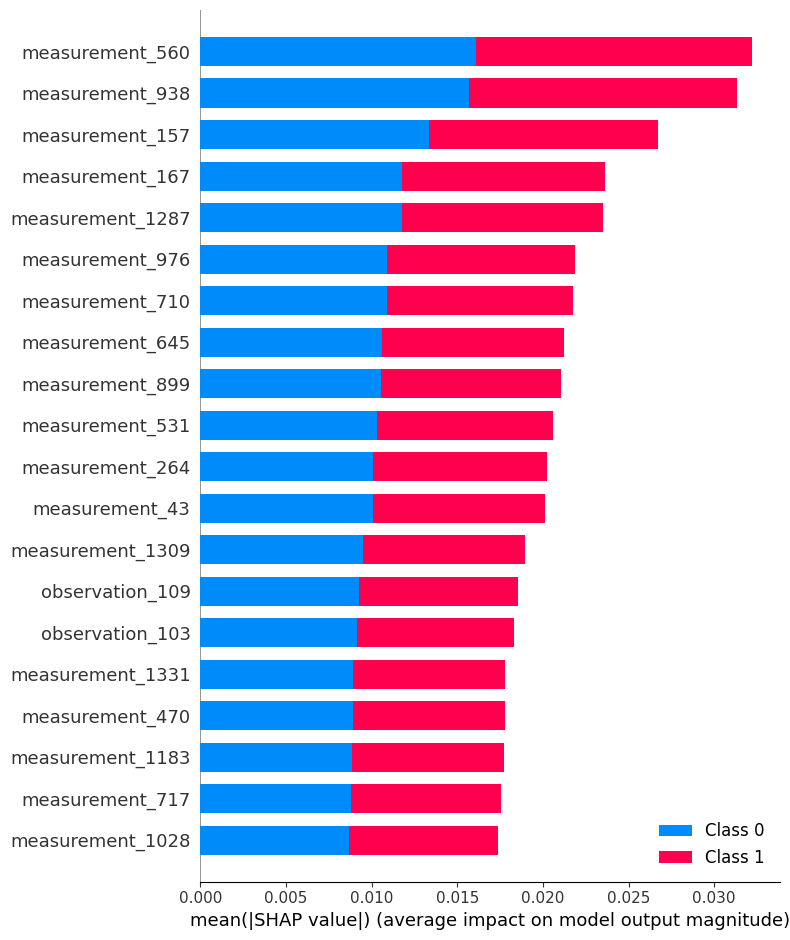

In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_selected.iloc[:100, :])
shap.summary_plot(shap_values, X_test_selected.iloc[:100, :])